In [58]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [59]:
# Global Parameters
DIR = '/Users/xiuqi/Downloads/Data/Bosch'

TRAIN_NUMERIC = "{0}/train_numeric.csv".format(DIR)
TRAIN_DATE = "{0}/train_date.csv".format(DIR)
TEST_NUMERIC = "{0}/test_numeric.csv".format(DIR)
TEST_DATE = "{0}/test_date.csv".format(DIR)

ID_COL = 'Id'
TARGET_COL = 'Response'
SEED = 0
CHUNKSIZE = 10000
NROWS = 50000

In [60]:
train = pd.read_csv(TRAIN_NUMERIC,usecols=[ID_COL,TARGET_COL],nrows=NROWS)
test = pd.read_csv(TEST_DATE,usecols=[ID_COL],nrows=NROWS)

In [66]:
train['StartTime'] = -1
test['StartTime'] = -1

nrows = 0
for tr,te in zip(pd.read_csv(TRAIN_DATE,chunksize=CHUNKSIZE),
                 pd.read_csv(TEST_DATE,chunksize=CHUNKSIZE)):
    feats = np.setdiff1d(tr.columns.values,ID_COL)
    
    stime_tr = tr[feats].mean(axis=1).values
    stime_te = te[feats].mean(axis=1).values
    
    train.loc[train[ID_COL].isin(tr[ID_COL]),'StartTime'] = stime_tr
    test.loc[test[ID_COL].isin(te[ID_COL]),'StartTime'] = stime_te
    
    nrows += CHUNKSIZE
    if nrows >= NROWS:
        break

In [67]:
ntrain = train.shape[0]
train_test = pd.concat((train, test)).reset_index(drop=True).reset_index(drop=False)

In [68]:
# Generate magic features
train_test['magic1'] = train_test[ID_COL].diff().fillna(999999).astype(int)
train_test['magic2'] = train_test[ID_COL].iloc[::-1].diff().fillna(999999).astype(int)

# Sort by Start time and Id
train_test = train_test.sort_values(by=['StartTime',ID_COL],ascending=True)

train_test['magic3'] = train_test[ID_COL].diff().fillna(999999).astype(int)
train_test['magic4'] = train_test[ID_COL].iloc[::-1].diff().fillna(999999).astype(int)

train_test = train_test.sort_values(by='index').drop(['index'],axis=1)
train = train_test.iloc[:ntrain,:]

In [79]:
import seaborn as sns
def twoplot(df,col,xaxis=None):
    if col not in df.columns.values:
        print("Error")
    ndf = pd.DataFrame(index=df.index)
    ndf[col] = df[col]
    ndf[xaxis] = df[xaxis] if xaxis else df.index
    ndf[TARGET_COL] = df[TARGET_COL]
    
    g = sns.FacetGrid(ndf,col=TARGET_COL,hue=TARGET_COL)
    g.map(plt.scatter,xaxis,col,alpha=.7,s=1)
    
    del ndf

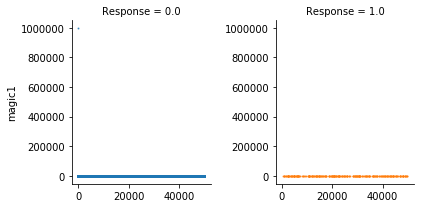

In [80]:
twoplot(train,'magic1')

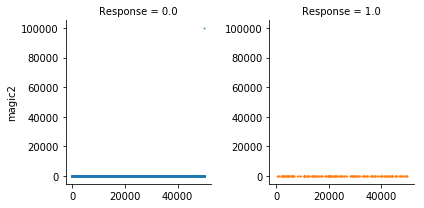

In [81]:
twoplot(train,'magic2')

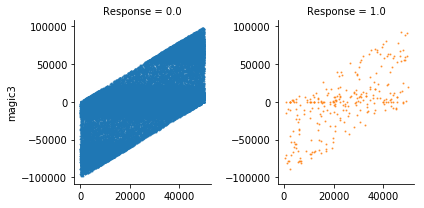

In [82]:
twoplot(train,'magic3')

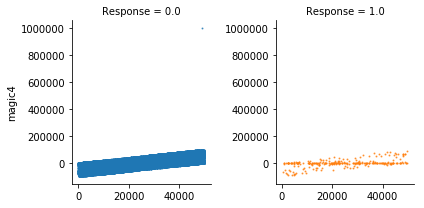

In [83]:
twoplot(train,'magic4')